# Hamiltonian Simulation
## VQE Solution to a Spin Hamiltonian's Ground State, Plotted Qubistically

This is a VQE solver for a spin Hamiltonian's ground state; tutorial see

https://github.com/Qiskit/qiskit-tutorials/blob/master/community/aqua/algorithm_introduction_with_vqe.ipynb

In [1]:
from qiskit.aqua import Operator
import pprint
pp = pprint.PrettyPrinter().pprint
from math import log

In [2]:
# next-to-nearest neighbour Heisenberg Hamiltonian
# scaled such that critical point at J2=.5
def Paulis_Heisenberg_NNN(N, J2, J1=1., verbose=False):
    terms = {
        'paulis': [
            list(h for h in [
                {'label': 'I'*i + 'XX' + 'I'*(N-i-2), 'coeff': {'real': J1, 'imag': 0}},
                {'label': 'I'*i + 'YY' + 'I'*(N-i-2), 'coeff': {'real': J1, 'imag': 0}},
                {'label': 'I'*i + 'ZZ' + 'I'*(N-i-2), 'coeff': {'real': J1, 'imag': 0}}
            ])
            for i in range(0, N-1)
        ] + [
            list(h for h in [
                {'label': 'I'*i + 'XIX' + 'I'*(N-i-3), 'coeff': {'real': J2, 'imag': 0}},
                {'label': 'I'*i + 'YIY' + 'I'*(N-i-3), 'coeff': {'real': J2, 'imag': 0}},
                {'label': 'I'*i + 'ZIZ' + 'I'*(N-i-3), 'coeff': {'real': J2, 'imag': 0}}
            ])
            for i in range(0, N-2)
        ]
    }
    terms['paulis'] = [ h for hh in terms['paulis'] for h in hh ]
    
    if verbose: pp(terms['paulis'])
    
    return Operator.load_from_dict(terms)

Paulis_Heisenberg_NNN(8, .4)

In [3]:
# nearest neighbour transverse-field Ising
# scaled such that critical point at Γ=.5
def Paulis_TIM_NN(N, Γ, J=.5, verbose=False):
    terms = {
        'paulis': [
            list(h for h in [
                {'label': 'I'*i + 'ZZ' + 'I'*(N-i-2), 'coeff': {'real': J, 'imag': 0}}
            ])
            for i in range(0, N-1)
        ] + [
            list(h for h in [
                {'label': 'I'*i + 'X' + 'I'*(N-i-1), 'coeff': {'real': -Γ, 'imag': 0}}
            ])
            for i in range(0, N)
        ]
    }
    terms['paulis'] = [ h for hh in terms['paulis'] for h in hh ]
    
    if verbose: pp(terms['paulis'])
    
    return Operator.load_from_dict(terms)

Paulis_TIM_NN(4, .5)

## QUBISM Plot

In [4]:
import numpy as np 
import matplotlib.pyplot as plt

In [5]:
def qubism_indices(depth):
    def _qubism_indices(depth, prefix):
        if depth == 0:
            return prefix

        return np.block([[
            _qubism_indices(depth-1, prefix+'00'), _qubism_indices(depth-1, prefix+'01')
        ], [
            _qubism_indices(depth-1, prefix+'10'), _qubism_indices(depth-1, prefix+'11')
        ]])

    arr = np.array(_qubism_indices(depth, ''))
    f = np.vectorize(lambda s: int(s, 2))
    
    return f(arr)
        
qubism_indices(3)

array([[ 0,  1,  4,  5, 16, 17, 20, 21],
       [ 2,  3,  6,  7, 18, 19, 22, 23],
       [ 8,  9, 12, 13, 24, 25, 28, 29],
       [10, 11, 14, 15, 26, 27, 30, 31],
       [32, 33, 36, 37, 48, 49, 52, 53],
       [34, 35, 38, 39, 50, 51, 54, 55],
       [40, 41, 44, 45, 56, 57, 60, 61],
       [42, 43, 46, 47, 58, 59, 62, 63]])

In [6]:
def qubism_array(vector, verbose=False):
    base4exp = log(len(vector), 4)
    assert base4exp > 0 and base4exp % 1 == 0., "input has to be vector of length 4^n"
    
    if verbose: print('qubism size: ', 2*base4exp, 'x', 2*base4exp)
    indices = qubism_indices(base4exp)
    shuffled = np.array(vector)[indices]
    
    return np.abs(shuffled)

In [7]:
def qubism_plot(vector, vmax_vec=None, plot=None):
    # bias somewhat so that small numbers show up stronger
    vector_mapped = np.power(vector, .5)
    # take maximum range from own vector by default
    vmax_vec = vector_mapped if not isinstance(vmax_vec, np.ndarray) else np.power(vmax_vec, .5)
    vmax = np.max(np.abs(vmax_vec))
    
    if plot == None:
        fig, plot = plt.subplots(1, 1, figsize=(8,8))
        
    plot.set_xticks([], []) 
    plot.set_yticks([], [])
    plot.imshow(qubism_array(vector_mapped), cmap='viridis', vmin=0, vmax=vmax)

## Solve Exactly

In [8]:
from qiskit.aqua.algorithms import ExactEigensolver

In [9]:
exact_eigensolver = ExactEigensolver(Paulis_TIM_NN(14, .8))
result_cl = exact_eigensolver.run()

print(result_cl['energy'])

-12.238512061010736


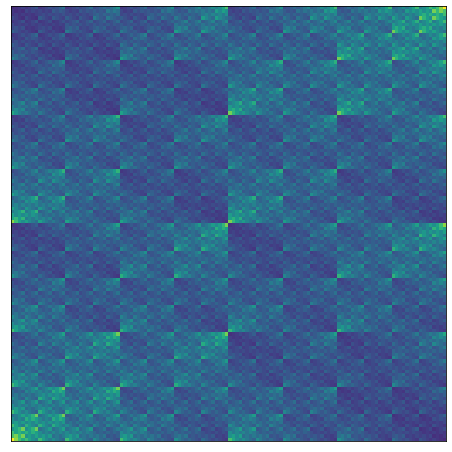

In [10]:
qubism_plot(result_cl['wavefunction'][0])

## VQE

In [11]:
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput

In [12]:
def AquaCfgDict(depth, rounds, method='SLSQP', optimizer_rounds_name='maxiter'):
    return {
        'algorithm': {
            'name': 'VQE',
            'operator_mode': 'matrix'
        },
        'variational_form': {
            'name': 'RYRZ',
            'depth': 4,
            'entanglement': 'full'
        },
        'optimizer': {
            'name': method,
            optimizer_rounds_name: rounds
        },
        'backend': {
            'name': 'statevector_simulator',
            'provider': 'qiskit.BasicAer'
        }
    }

In [13]:
algo_input = EnergyInput(Paulis_Heisenberg_NNN(2, .8))
result_q = run_algorithm(AquaCfgDict(2, 500), algo_input)

print(result_q['energy'])

-2.9999999999992633


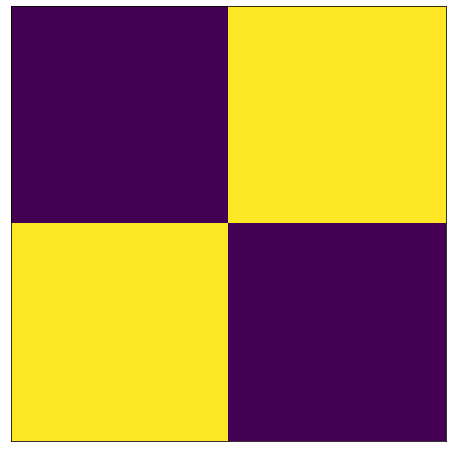

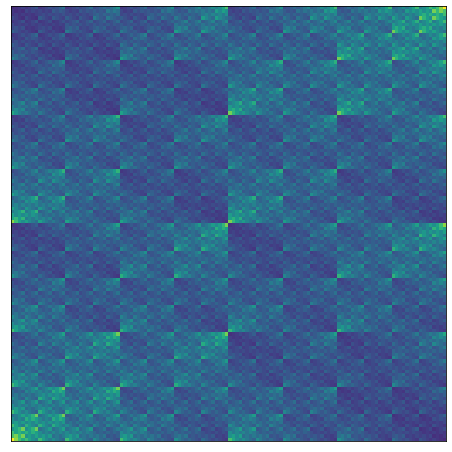

In [14]:
qubism_plot(result_q['min_vector'], result_cl['wavefunction'][0])
qubism_plot(result_cl['wavefunction'][0])

## On-Device

# Benchmark
## Automated Plots and Runs for the IBM Q Experience

In [ ]:
# data collection
results = {}
for N in [2, 4, 6]:
    for ham_id, factory in [('heisenberg', Paulis_Heisenberg_NNN), ('ising', Paulis_TIM_NN)]:
        for param in [0., .25, .4, .466, .5, .533, .6, .75, 1.]:
            key = (N,ham_id,param)
            entry = results[key] = {}
    
            # local operators
            paulis = factory(N, param)
            
            # EXACT
            # diagonalize exactly, we only need to do this once
            exact_eigensolver = ExactEigensolver(paulis)
            result_cl = exact_eigensolver.run()

            print(key, result_cl['energy'])
            entry['exact'] = {
                'energy': result_cl['energy'],
                'state': result_cl['wavefunction'][0]
            }
            
            # SIMULATION
            # we run a few rounds, each one will choose its own starting point
            entry['simulation'] = { 'energy': 10**10 }
            
            def simulation_instance(run):
                algo_input = EnergyInput(paulis)
                result_sim = run_algorithm(AquaCfgDict(N+1, 1500*N, method='SLSQP'), algo_input)

                energy = result_sim['energy']
                if energy < entry['simulation']['energy']:
                    print('found best energy in run', run, ': ', result_sim['energy'])
                    entry['simulation'] = {
                        'energy': result_sim['energy'],
                        'state': result_sim['min_vector']
                    }
            
            # TODO: parallelize
            for run in range(10):
                simulation_instance(run)
                
            # IBM Q Run
            pass

(2, 'heisenberg', 0.0) -3.0
found best energy in run 0 :  -2.99999990006502
found best energy in run 2 :  -2.9999999763225595
found best energy in run 5 :  -2.9999999765236702
found best energy in run 6 :  -2.9999999994951017
(2, 'heisenberg', 0.25) -3.0000000000000004
found best energy in run 0 :  -2.9999998821538414
found best energy in run 1 :  -2.999999922651825
found best energy in run 2 :  -2.999999987497889
found best energy in run 3 :  -2.9999999898369456
found best energy in run 6 :  -2.9999999966310114
(2, 'heisenberg', 0.4) -3.0
found best energy in run 0 :  -2.9999999999993987
(2, 'heisenberg', 0.466) -3.000000000000001
found best energy in run 0 :  -2.999999955118434
found best energy in run 1 :  -2.9999999925479175
found best energy in run 2 :  -2.9999999943852456
found best energy in run 6 :  -2.9999999963288655
found best energy in run 7 :  -2.99999999651328
found best energy in run 8 :  -2.9999999983588532
(2, 'heisenberg', 0.5) -3.0
found best energy in run 0 :  -2.99

In [ ]:
# save and load runs
import pickle
with open(r"results-reference.pickle", "wb") as output_file:
    pickle.dump(results, output_file)
    pass


In [ ]:
'''
with open(r"results-reference.pickle", "rb") as input_file:
    print(pickle.load(input_file))
'''

In [ ]:
# plotting
def index_2d(ll, v):
    for i, x in enumerate(ll):
        if v in x: return (i, x.index(v))
        
layout_lookup = [[
    (N, ham_id, param)
    for ham_id in ['ising', 'heisenberg']
    for N in [2, 4, 6]
] for param in [.0, .1, .2, .3, .4, .5]]

print(index_2d(layout_lookup,(2, 'heisenberg', 0, 'exact')))
pp(layout_lookup)

In [ ]:
import matplotlib.gridspec as gridspec

plt.axis('off')
plt.tight_layout()

fig = plt.figure(figsize=(6, 12))
nx = len(layout_lookup)
ny = len(layout_lookup[0])
outer = gridspec.GridSpec(nx, ny, wspace=0.2, hspace=0.2)

for key in results:
    N, run_id, param = key       
    
    entry = results[key]
    cx,cy = index_2d(layout_lookup, key)
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[cx, cy], wspace=0.05, hspace=0.05)
    
    plot = plt.Subplot(fig, inner[0])
    qubism_plot(entry['exact']['state'], plot=plot)
    fig.add_subplot(plot)
    
    plot = plt.Subplot(fig, inner[1])
    qubism_plot(entry['simulation']['state'], plot=plot, vmax_vec=entry['exact']['state'])
    fig.add_subplot(plot)
    

fig.savefig(r'qubism-plots.pdf', bbox_inches='tight')
    